## Verificação de Algoritmos

Neste notebook serao testadas tecnicas mais tradicionais para classificacao das mensagens. Testado um treinamento nao supervisionado usando o Spectral Clustering, e tambem um treinamento supervisionado usando alguns algoritmos classificadores.

In [5]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [6]:
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics.pairwise import (
    cosine_similarity, 
    cosine_distances,
    laplacian_kernel, 
    euclidean_distances, 
    sigmoid_kernel, 
    chi2_kernel,
    polynomial_kernel,
    rbf_kernel
)
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, v_measure_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import SpectralClustering

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [7]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [8]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['meu deus com febr coron virus voc put que par man meu moment' 1]
2044


### Unsupervised Learning : Spectral Clustering

Baseado no paper de referência: [Opinion Mining on Twitter Data using Unsupervised Learning Technique](https://www.ijcaonline.org/archives/volume148/number12/unnisa-2016-ijca-911317.pdf)

In [49]:
start = time.time()

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)
        y = textos[:, 1].astype(np.int).ravel()

        for metric in (
            cosine_distances,
            euclidean_distances, 
            sigmoid_kernel, 
            polynomial_kernel,
            rbf_kernel,
            # Usam apenas 1 cpu para calcular... muito lento
            # laplacian_kernel, 
            # chi2_kernel,
        ):
            for assign_labels in ["discretize", "kmeans"]:
                clustering = SpectralClustering(
                    n_clusters=2,
                    eigen_solver="amg",
                    assign_labels=assign_labels,
                    affinity="precomputed_nearest_neighbors",
                    random_state=0,
                    n_jobs=-1
                ).fit(metric(X))

                pred = clustering.labels_
                acc = round(accuracy_score(pred, y) * 100, 2)
                f1 = round(f1_score(pred, y) * 100, 2)
                vm = round(v_measure_score(y, pred), 2)
                validacoes.append((
                    vectorizer.__class__.__name__,
                    norm_name,
                    ngram_range,
                    metric.__name__,
                    assign_labels,
                    acc, 
                    f1,
                    vm
                ))

print(time.time() - start)

38.02134561538696


In [50]:
columns = ["Vectorizer", "Scaler", "NGram", "Metric", "AssignLabels", "Accuracy", "F1", "V-Measure"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "V-Measure", "Vectorizer", "Metric"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Metric,AssignLabels,Accuracy,F1,V-Measure
13,CountVectorizer,StandardScaler,"(1, 2)",euclidean_distances,kmeans,47.70,56.42,0.01
35,CountVectorizer,StandardScaler,"(3, 3)",sigmoid_kernel,kmeans,39.43,54.59,0.00
118,TfidfVectorizer,None,"(3, 3)",rbf_kernel,discretize,40.66,54.14,0.00
114,TfidfVectorizer,None,"(3, 3)",sigmoid_kernel,discretize,40.46,53.46,0.00
116,TfidfVectorizer,None,"(3, 3)",polynomial_kernel,discretize,40.46,53.46,0.00
34,CountVectorizer,StandardScaler,"(3, 3)",sigmoid_kernel,discretize,40.46,53.46,0.00
74,CountVectorizer,None,"(3, 3)",sigmoid_kernel,discretize,40.46,53.46,0.00
36,CountVectorizer,StandardScaler,"(3, 3)",polynomial_kernel,discretize,40.46,53.46,0.00
76,CountVectorizer,None,"(3, 3)",polynomial_kernel,discretize,40.46,53.46,0.00
65,CountVectorizer,None,"(1, 3)",sigmoid_kernel,kmeans,44.23,50.99,0.00


              precision    recall  f1-score   support

           0       0.73      0.23      0.35      1249
           1       0.42      0.87      0.56       795

    accuracy                           0.48      2044
   macro avg       0.58      0.55      0.46      2044
weighted avg       0.61      0.48      0.43      2044



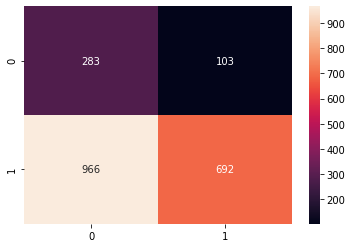

In [51]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(textos[:, 0])
X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

clustering = SpectralClustering(
    n_clusters=2,
    eigen_solver="amg",
    assign_labels="kmeans",
    affinity="precomputed_nearest_neighbors",
    random_state=0,
    n_jobs=-1
).fit(euclidean_distances(X))
pred = clustering.labels_

print(classification_report(y, pred))

df_cm = confusion_matrix(pred, y)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

### Supervised Learning

Parcialmente baseado no paper: [Towards detecting influenza epidemics by analyzing Twitter messages](https://dl.acm.org/doi/pdf/10.1145/1964858.1964874)

In [52]:
start = time.time()

classifiers = [
    LogisticRegression(
        random_state=0,
        multi_class="ovr",
        n_jobs=-1
    ), 
    SGDClassifier(
        random_state=0,
        n_jobs=-1,
        max_iter=1500,
        n_iter_no_change=10
    ), 
    SVC(
        kernel="rbf",
        random_state=0
    ),
]

validacoes = []
for Vectorizer, Norm in [(CountVectorizer, StandardScaler), (CountVectorizer, None), (TfidfVectorizer, None)]:
    for ngram_range in [(1, 1), (1, 2), (1, 3), (3, 3)]:
        vectorizer = Vectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(textos[:, 0])
        y = textos[:, 1].astype(np.int).ravel()
        
        norm_name = None
        if Norm:
            norm_name = Norm.__name__
            X = Norm(with_mean=False).fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        for Classifier in classifiers:
            clf = Classifier.fit(X_train, y_train)
            pred = clf.predict(X_test)

            acc = round(accuracy_score(pred, y_test) * 100, 2)
            f1 = round(f1_score(pred, y_test) * 100, 2)
            validacoes.append((
                vectorizer.__class__.__name__,
                norm_name,
                ngram_range,
                clf.__class__.__name__,
                acc, 
                f1
            ))

print(time.time() - start)

9.136971235275269


In [53]:
columns = ["Vectorizer", "Scaler", "NGram", "Classifier", "Accuracy", "F1"]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1", "Accuracy", "Vectorizer", "NGram"], ascending=False)
df.head(25)

,Vectorizer,Scaler,NGram,Classifier,Accuracy,F1
31,TfidfVectorizer,None,"(1, 3)",SGDClassifier,75.79,64.77
18,CountVectorizer,None,"(1, 3)",LogisticRegression,71.88,64.62
28,TfidfVectorizer,None,"(1, 2)",SGDClassifier,75.79,64.52
15,CountVectorizer,None,"(1, 2)",LogisticRegression,72.13,64.38
19,CountVectorizer,None,"(1, 3)",SGDClassifier,72.62,64.10
25,TfidfVectorizer,None,"(1, 1)",SGDClassifier,72.13,63.23
17,CountVectorizer,None,"(1, 2)",SVC,73.11,63.09
3,CountVectorizer,StandardScaler,"(1, 2)",LogisticRegression,66.26,62.90
12,CountVectorizer,None,"(1, 1)",LogisticRegression,70.90,62.70
14,CountVectorizer,None,"(1, 1)",SVC,72.13,62.25


precision    recall  f1-score   support

           0       0.78      0.86      0.82       255
           1       0.73      0.60      0.66       154

    accuracy                           0.77       409
   macro avg       0.75      0.73      0.74       409
weighted avg       0.76      0.77      0.76       409



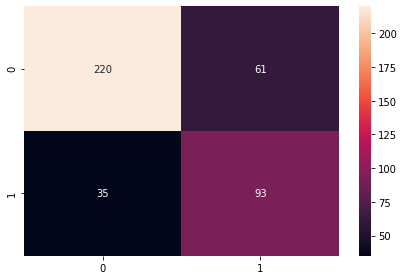

In [79]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = SGDClassifier(
    alpha=1e-7,
    random_state=0,
    n_jobs=-1,
    max_iter=3000,
    n_iter_no_change=50
).fit(X_train, y_train)
pred = clf.predict(X_test)

# loss = clf.loss_curve_
# plt.plot(range(1, len(loss) + 1), loss)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

### Supervised Learning : Ensemble

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       255
           1       0.73      0.40      0.51       154

    accuracy                           0.72       409
   macro avg       0.72      0.65      0.66       409
weighted avg       0.72      0.72      0.69       409



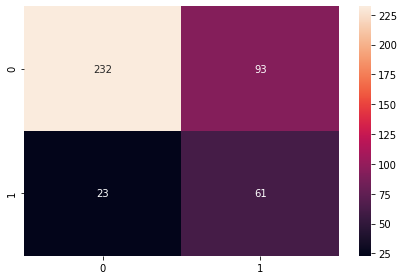

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X = vectorizer.fit_transform(textos[:, 0])
# X = StandardScaler(with_mean=False).fit_transform(X)
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf1 = LogisticRegression(random_state=0, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=0)
clf3 = MultinomialNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('mnb', clf3)],
    voting='soft', weights=[1, 2, 1], n_jobs=-1
).fit(X_train, y_train)
pred = eclf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()